In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from datasets import load_dataset
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast  # For mixed precision training


In [ ]:

# Load the dataset from Hugging Face
dataset = load_dataset("funkepal/medicinal_plant_images")

# Data preprocessing
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

# Transform for preprocessing images
transform = transforms.Compose([
    transforms.Resize((224, 224)),# Resize to 224x224 for ViT
    transforms.RandomResizedCrop(224),  # Randomly resize and crop images
    transforms.RandomHorizontalFlip(),
    transforms.Lambda(lambda img: img.convert("RGB")),  # Convert image to RGB if it has an alpha channel
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)  # Normalize based on the pre-trained ViT model
])



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/250M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/60.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4796 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1199 [00:00<?, ? examples/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:

# Custom dataset class to handle transformations
class PlantDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image']
        label = item['label']

        # Apply the transformation to the image
        image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Apply the transformation using the custom dataset class
train_dataset = PlantDataset(dataset['train'], transform)
test_dataset = PlantDataset(dataset['test'], transform)

# DataLoader for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Adjust batch size as needed
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:

# Define CNN for Feature Extraction
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        return x

# Instantiate CNN feature extractor
cnn_extractor = CNNFeatureExtractor()




In [ ]:
# Vision Transformer for Classification
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.cnn = cnn_extractor
        self.vit = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224",
            num_labels=41,  # Number of classes in your dataset
            ignore_mismatched_sizes=True  # Add this line to ignore size mismatches
        )
        self.conv_proj = nn.Conv2d(128, 3, kernel_size=1)  # Define the projection layer here

    def forward(self, x):
        # Extract features using CNN
        x = self.cnn(x)
        # Resize features to 224x224 for ViT using interpolation
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        # Project features to 3 channels using a 1x1 convolution
        x = self.conv_proj(x)  # Use the defined projection layer
        outputs = self.vit(pixel_values=x)  # Use Vision Transformer for classification
        return outputs.logits

In [ ]:

# Instantiate the model
model = HybridModel()

# Optimizer and Loss Function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Mixed Precision Training
scaler = GradScaler()  # Mixed precision scaler

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([41]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([41, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-7-fe4e7b745137>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Mixed precision scaler


In [ ]:
# Training the Model
def train(model, train_loader, optimizer, criterion, device, scaler):
    model.train()
    total_loss = 0
    correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Clear gradients

        with autocast():  # Mixed precision
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss

        scaler.scale(loss).backward()  # Backpropagation with scaled gradients
        scaler.step(optimizer)  # Update weights
        scaler.update()

        total_loss += loss.item()  # Accumulate loss
        correct += (outputs.argmax(1) == labels).sum().item()  # Count correct predictions

        torch.cuda.empty_cache()  # Free up GPU memory

    accuracy = correct / len(train_loader.dataset)
    return total_loss / len(train_loader), accuracy  # Return average loss and accuracy

# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()  # Calculate accuracy

            torch.cuda.empty_cache()  # Free up GPU memory

    accuracy = correct / len(test_loader.dataset)
    return total_loss / len(test_loader), accuracy  # Return average loss and accuracy

# Train and evaluate the model
num_epochs = 10
total_train_loss = 0
total_test_loss = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Training phase
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device, scaler)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Testing phase
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Accumulate losses (not accuracies) if you need them for reference
    total_train_loss += train_loss
    total_test_loss += test_loss

# Print final total loss and accuracy after all epochs
print(f"\nTotal Training Loss after {num_epochs} epochs: {total_train_loss:.4f}")
print(f"Total Test Loss after {num_epochs} epochs: {total_test_loss:.4f}")
print(f"Final Training Accuracy after {num_epochs} epochs: {train_accuracy:.4f}")  # Final epoch accuracy
print(f"Final Test Accuracy after {num_epochs} epochs: {test_accuracy:.4f}")  # Final epoch accuracy


Epoch 1/10


<ipython-input-9-588fb68a4775>:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision


Train Loss: 1.0654, Train Accuracy: 0.7285
Test Loss: 0.7138, Test Accuracy: 0.8123
Epoch 2/10
Train Loss: 0.4305, Train Accuracy: 0.8820
Test Loss: 0.4879, Test Accuracy: 0.8607
Epoch 3/10
Train Loss: 0.2786, Train Accuracy: 0.9266
Test Loss: 0.3727, Test Accuracy: 0.8957
Epoch 4/10
Train Loss: 0.2097, Train Accuracy: 0.9433
Test Loss: 0.2618, Test Accuracy: 0.9216
Epoch 5/10
Train Loss: 0.1870, Train Accuracy: 0.9470
Test Loss: 0.2702, Test Accuracy: 0.9224
Epoch 6/10
Train Loss: 0.2065, Train Accuracy: 0.9422
Test Loss: 0.2431, Test Accuracy: 0.9374
Epoch 7/10
Train Loss: 0.1634, Train Accuracy: 0.9537
Test Loss: 0.2637, Test Accuracy: 0.9283
Epoch 8/10
Train Loss: 0.1527, Train Accuracy: 0.9564
Test Loss: 0.2561, Test Accuracy: 0.9274
Epoch 9/10
Train Loss: 0.1359, Train Accuracy: 0.9629
Test Loss: 0.1784, Test Accuracy: 0.9416
Epoch 10/10
Train Loss: 0.1305, Train Accuracy: 0.9612
Test Loss: 0.1878, Test Accuracy: 0.9399

Total Training Loss after 10 epochs: 2.9601
Total Test Loss

In [ ]:
# Load the dataset from Hugging Face
from datasets import load_dataset
dataset = load_dataset("funkepal/medicinal_plant_images")

# Get the feature information (label mapping)
label_names = dataset['train'].features['label'].names

# Print the label names
print(f"\nThere are {len(label_names)} unique image class names:")
for idx, label in enumerate(label_names):
    print(f"Label {idx}: {label}")

# Optionally, inspect the structure of an individual sample (e.g., the first image and label)
first_sample = dataset['train'][0]
label_of_first_sample = label_names[first_sample['label']]

print(f"\nExample sample from dataset:")
print(f"Image: {first_sample['image']} \nLabel: {label_of_first_sample}")

# Count the occurrences of each class in the dataset using the label names
from collections import Counter

# Create a Counter for the labels (mapped to their names)
label_counts = Counter(label_names[item['label']] for item in dataset['train'])

print("\nLabel Distribution (Count of each class in the training set):")
for label, count in label_counts.items():
    print(f"{label}: {count} images")



There are 41 unique image class names:
Label 0: Aloevera
Label 1: Amla
Label 2: Amruta_Balli
Label 3: Arali
Label 4: Ashoka
Label 5: Ashwagandha
Label 6: Avacado
Label 7: Bamboo
Label 8: Basale
Label 9: Betel
Label 10: Betel_Nut
Label 11: Brahmi
Label 12: Castor
Label 13: Curry_Leaf
Label 14: Doddapatre
Label 15: Ekka
Label 16: Ganike
Label 17: Gauva
Label 18: Geranium
Label 19: Henna
Label 20: Hibiscus
Label 21: Honge
Label 22: Insulin
Label 23: Jasmine
Label 24: Lemon
Label 25: Lemon_grass
Label 26: Mango
Label 27: Mint
Label 28: Nagadali
Label 29: Neem
Label 30: Nithyapushpa
Label 31: Nooni
Label 32: Not_a_plant
Label 33: Pappaya
Label 34: Pepper
Label 35: Pomegranate
Label 36: Raktachandini
Label 37: Rose
Label 38: Sapota
Label 39: Tulasi
Label 40: Wood_sorel

Example sample from dataset:
Image: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x277 at 0x7CDB6C74DE50> 
Label: Amla

Label Distribution (Count of each class in the training set):
Amla: 121 images
Hibiscus: 130

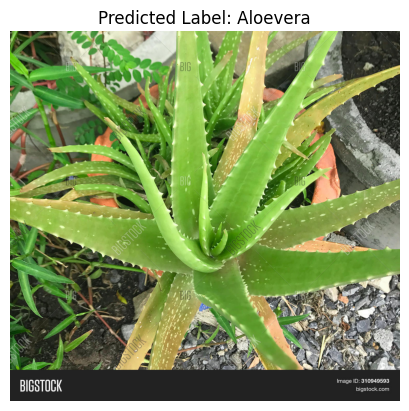

The model predicts the image is of: Aloevera


In [ ]:
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Preprocess function for the new image
def preprocess_image(image_path, feature_extractor):
    image = Image.open(image_path).convert('RGB')  # Convert image to RGB

    # Define the transformations (resize, convert to tensor, normalize)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to the required input size for the model
        transforms.ToTensor(),  # Convert the image to tensor
        transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
    ])

    transformed_image = transform(image).unsqueeze(0)  # Add batch dimension
    return transformed_image, image  # Return both the tensor and original image for display

# ... (rest of your code)
# Function to classify an image using the model
def classify_image(model, image_tensor, device):
    model.eval()  # Set the model to evaluation mode
    image_tensor = image_tensor.to(device)  # Move the image tensor to the same device as the model

    with torch.no_grad():
        outputs = model(image_tensor)  # Forward pass through the model
        # Directly use outputs without logits attribute
        predicted_class_idx = torch.argmax(outputs, dim=1).item()  # Get the predicted class index

    return predicted_class_idx

# Load and preprocess the new image
image_path = '/content/aar.jpg' # Specify the path to your new image
image_tensor, original_image = preprocess_image(image_path, feature_extractor)

# Load the model and move it to the same device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Classify the new image
predicted_class_idx = classify_image(model, image_tensor, device)

# Get the actual label name from the predicted class index
predicted_label = label_names[predicted_class_idx]

# Display the original image and the predicted class
plt.imshow(original_image)
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()

# Print the result
print(f"The model predicts the image is of: {predicted_label}")


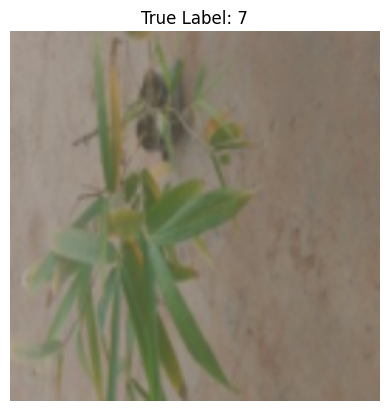

In [ ]:
# Access the first item from the test dataset
test_image, true_label = test_dataset[20]

# Convert the tensor back to a PIL-compatible format for visualization
image_np = test_image.permute(1, 2, 0).numpy()  # Convert CHW to HWC
image_np = (image_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Unnormalize
image_np = image_np.clip(0, 1)  # Ensure pixel values are within [0, 1]

# Plot the image
import matplotlib.pyplot as plt
plt.imshow(image_np)
plt.axis("off")
plt.title(f"True Label: {true_label}")
plt.show()


In [ ]:
# Access the first item from the test dataset
test_image, true_label = test_dataset[20]

# Prepare the image for the model (add batch dimension)
test_image_batch = test_image.unsqueeze(0)  # Shape: [1, C, H, W]

# Move the input to the same device as the model
test_image_batch = test_image_batch.to(device)

# Predict the label using the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(test_image_batch)
    predicted_label = torch.argmax(output, dim=1).item()  # Get the predicted class index

# Print the predicted label
print(f"Predicted Label: {predicted_label}")
print(f"True Label: {true_label}")

Predicted Label: 7
True Label: 7


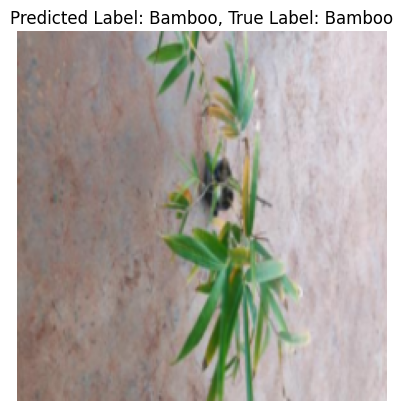

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms

# Access the first item from the test dataset
test_image, true_label = test_dataset[20]

# Prepare the image for the model (add batch dimension)
test_image_batch = test_image.unsqueeze(0)  # Shape: [1, C, H, W]

# Move the input to the same device as the model
test_image_batch = test_image_batch.to(device)

# Predict the label using the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(test_image_batch)
    predicted_label_index = torch.argmax(output, dim=1).item()  # Get the predicted class index

# Get the predicted label name
predicted_label_name = label_names[predicted_label_index]

# Denormalize the image for visualization
# (Assuming you've defined 'mean' and 'std' for your normalization)
inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(feature_extractor.image_mean, feature_extractor.image_std)],
    std=[1 / s for s in feature_extractor.image_std]
)
denormalized_image = inv_normalize(test_image)

# Convert the tensor back to a PIL-compatible format for visualization
image_np = denormalized_image.permute(1, 2, 0).cpu().numpy()  # Convert CHW to HWC
image_np = image_np.clip(0, 1)  # Ensure pixel values are within [0, 1]

# Plot the image
plt.imshow(image_np)
plt.axis("off")
plt.title(f"Predicted Label: {predicted_label_name}, True Label: {label_names[true_label.item()]}")
plt.show()

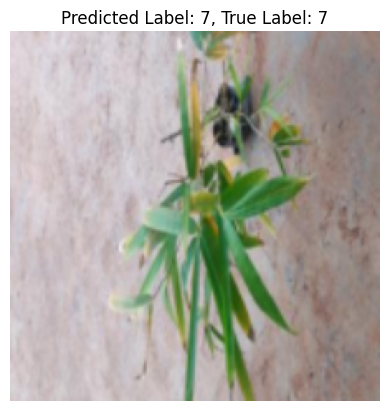

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms

# Step 5: Select a test image
test_image_info = test_dataset[20]  # Use the first image in the test dataset
image = test_image_info[0] # Access the image using numerical index 0
label = test_image_info[1]  # Access the label using numerical index 1

# The image is already a tensor, no need to apply transform again
input_image = image.unsqueeze(0)  # Add batch dimension if needed

# Step 6: Predict the label
with torch.no_grad():
    output = model(input_image.to(device)) # Ensure input is on the correct device
    predicted_label = torch.argmax(output, dim=1).item()

# Step 7: Display the image and predicted label
# Denormalize the image before converting to PIL Image
mean = feature_extractor.image_mean
std = feature_extractor.image_std

# Create an inverse transform to reverse the normalization
inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)],
    std=[1 / s for s in std]
)

# Denormalize the image
denormalized_image = inv_normalize(image)

# Convert the denormalized image tensor to a PIL Image for display
image_to_display = transforms.ToPILImage()(denormalized_image)

plt.imshow(image_to_display)
plt.axis("off")
plt.title(f"Predicted Label: {predicted_label}, True Label: {label}")
plt.show()

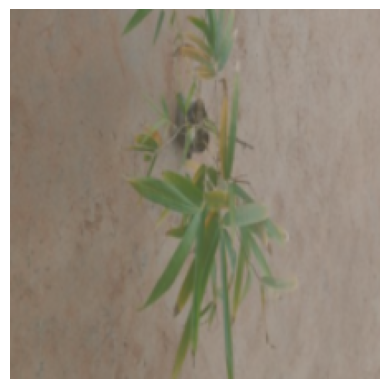

In [ ]:
# Access the first item from the test dataset
test_image, _ = test_dataset[20]

# Convert the tensor back to a PIL-compatible format for visualization
image_np = test_image.permute(1, 2, 0).numpy()  # Convert CHW to HWC
image_np = (image_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Unnormalize
image_np = image_np.clip(0, 1)  # Ensure pixel values are within [0, 1]

# Plot the image
import matplotlib.pyplot as plt
plt.imshow(image_np)
plt.axis("off")
plt.show()


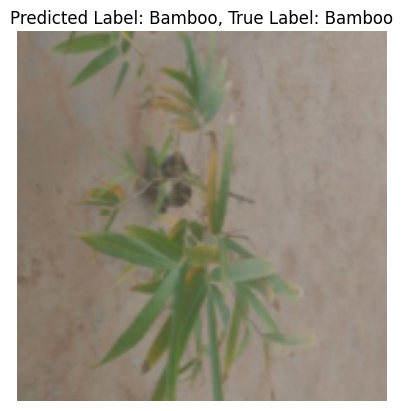

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms
from datasets import load_dataset # Import load_dataset



# Step 7: Test a single image from the test dataset
test_image, true_label = test_dataset[20]  # Use the first image in the test dataset
test_image_batch = test_image.unsqueeze(0)  # Add batch dimension

# Reload the dataset to get label names (or define them explicitly if known)
dataset = load_dataset("funkepal/medicinal_plant_images") # Reload dataset
label_names = dataset['train'].features['label'].names # Get label names

# Step 8: Predict the label
with torch.no_grad():
    # Move the input tensor to the same device as the model
    output = model(test_image_batch.to(device))
    predicted_label_index = torch.argmax(output, dim=1).item()  # Get the predicted label index
    predicted_label_name = label_names[predicted_label_index] # Get the corresponding label name

# Step 9: Visualize the image and the predicted label
# Convert the tensor back to a PIL image for visualization
test_image_np = test_image.permute(1, 2, 0).numpy()  # Convert CHW to HWC
test_image_np = (test_image_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Unnormalize
test_image_np = test_image_np.clip(0, 1)

plt.imshow(test_image_np)
plt.axis("off")
plt.title(f"Predicted Label: {predicted_label_name}, True Label: {label_names[true_label.item()]}") # Use label names for display
plt.show()